# 3.3 학습 방법을 바꾼다


* **분석데이터**:
  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris

## 3.3.1 모델의 종류를 바꿔보자

In [1]:
# 라이브러리 로딩
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# 데이터 불러오기
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target

# 데이터분할
y = df['species']
X = df.drop(['species'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### ① KNN

In [2]:
from sklearn.neighbors import KNeighborsClassifier

neighbor_model = KNeighborsClassifier(n_neighbors=5)
neighbor_model.fit(X_train, y_train)
neighbor_model.score(X_test, y_test)

0.9736842105263158

### ② SVM

In [3]:
from sklearn.svm import SVC

svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)

0.9210526315789473

### ③ 앙상블

#### RandomForest

In [4]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
forest_model.score(X_test, y_test)

0.9210526315789473

#### GradientBoosting

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

gbm_model = GradientBoostingClassifier(random_state=42, n_estimators=300)
xgb_model = XGBClassifier(random_state=42, n_estimators=300)
lgb_model = LGBMClassifier(random_state=42, n_estimators=300)

model_list = [gbm_model, xgb_model, lgb_model]

for model in model_list:
    model.fit(X_train , y_train)
    score = model.score(X_test, y_test)
    model_name = model.__class__.__name__
    print('{0} 정확도: {1:.2f}'.format(model_name, score)) 

GradientBoostingClassifier 정확도: 0.97
XGBClassifier 정확도: 0.92
LGBMClassifier 정확도: 0.89


#### VotingClassifier 

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

neighbor_model = KNeighborsClassifier(n_neighbors=5)
forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

voting_model = VotingClassifier (estimators=[('RF',forest_model),('KNN',neighbor_model)] , voting='soft')

model_list = [neighbor_model, forest_model, voting_model]

for model in model_list:
    model.fit(X_train , y_train)
    score = model.score(X_test, y_test)
    model_name = model.__class__.__name__
    print('{0} 정확도: {1:.2f}'.format(model_name, score)) 


KNeighborsClassifier 정확도: 0.97
RandomForestClassifier 정확도: 0.92
VotingClassifier 정확도: 0.95


### ④ 로지스틱회귀

In [7]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_model.score(X_test, y_test)

0.9473684210526315

## 3.3.2 모델을 튜닝하자

In [8]:
# 라이브러리 로딩
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 데이터 불러오기
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target

# 데이터분할
y = df['species']
X = df.drop(['species'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# 모델 - DecisionTreeClassifier 
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# 파라미터
param = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}

# 학습 - param_grid의 하이퍼파라미터들을 순차적으로 학습
grid_trees = GridSearchCV(tree_model, param_grid=param, cv=3)
grid_trees.fit(X_train, y_train)

# 학습 결과 - GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_trees.cv_results_)
scores_df.iloc[:, 6:]

,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.657895,0.648649,0.675676,0.660740,0.011216,5
1,"{'max_depth': 1, 'min_samples_split': 3}",0.657895,0.648649,0.675676,0.660740,0.011216,5
2,"{'max_depth': 2, 'min_samples_split': 2}",0.947368,0.918919,0.945946,0.937411,0.013089,1
3,"{'max_depth': 2, 'min_samples_split': 3}",0.947368,0.918919,0.945946,0.937411,0.013089,1
4,"{'max_depth': 3, 'min_samples_split': 2}",0.921053,0.918919,0.945946,0.928639,0.012269,3
5,"{'max_depth': 3, 'min_samples_split': 3}",0.921053,0.918919,0.945946,0.928639,0.012269,3


In [9]:
# 최적 estimator
grid_trees.best_estimator_

DecisionTreeClassifier(max_depth=2, random_state=42)

In [10]:
# 최적 파라미터
grid_trees.best_params_

{'max_depth': 2, 'min_samples_split': 2}

In [11]:
# 최적 estimator의 성능
grid_trees.best_score_

0.9374110953058321

## 3.3.3 너무 오래 학습하지 않는다!

In [12]:
# 라이브러리 로딩
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# 데이터 불러오기
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target

# 데이터분할
y = df['species']
X = df.drop(['species'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, stratify=y_train)

# LGBMClassifier 생성
lgb_model = LGBMClassifier(n_estimators=300)

# 학습 - 학습 시, 검증용 데이터로 성능을 확인하면서 10회 이상 검증용 데이터의 정확도 개선이 되지 않을 경우 학습 종료
lgb_model.fit(X_train, y_train, early_stopping_rounds=10,  eval_set=[(X_train, y_train), (X_valid, y_valid)])

# 평가 - 테스트셋으로 평가
score = lgb_model.score(X_test, y_test)
print('정확도: {0:.2f}'.format(score))

[1]	training's multi_logloss: 0.968882	valid_1's multi_logloss: 0.968651
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.861379	valid_1's multi_logloss: 0.86096
[3]	training's multi_logloss: 0.770873	valid_1's multi_logloss: 0.770292
[4]	training's multi_logloss: 0.693403	valid_1's multi_logloss: 0.689264
[5]	training's multi_logloss: 0.626613	valid_1's multi_logloss: 0.622733
[6]	training's multi_logloss: 0.568154	valid_1's multi_logloss: 0.558807
[7]	training's multi_logloss: 0.516806	valid_1's multi_logloss: 0.504999
[8]	training's multi_logloss: 0.471769	valid_1's multi_logloss: 0.457762
[9]	training's multi_logloss: 0.43198	valid_1's multi_logloss: 0.415831
[10]	training's multi_logloss: 0.396787	valid_1's multi_logloss: 0.378772
[11]	training's multi_logloss: 0.365308	valid_1's multi_logloss: 0.34366
[12]	training's multi_logloss: 0.337347	valid_1's multi_logloss: 0.314202
[13]	training's multi_logloss: 0.312529	valid_1's multi_loglos

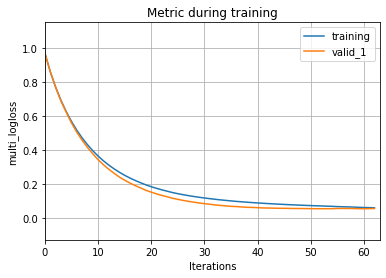

In [13]:
import lightgbm as lgb
lgb.plot_metric(lgb_model)

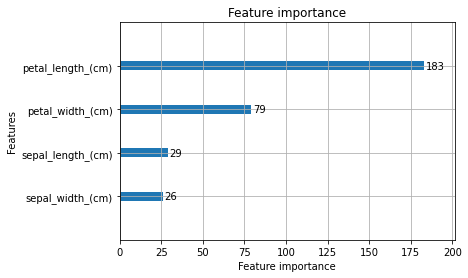

In [14]:
# 참고 - lgb_model에서 중요한 feature를 시각화하는 방법
from lightgbm import plot_importance
plot_importance(lgb_model)